# Ejercicio de procesamiento de imágenes en paralelo

## Librerías para imágenes

In [ ]:
!pip install Pillow numpy

## Funciones útiles para cargar y guardar imágenes.

In [ ]:
import numpy as np
from PIL import Image
import time
from IPython.display import display  # Importar para visualización

def cargar_imagen(ruta):
    return Image.open(ruta).convert('L')

def guardar_imagen(imagen, ruta):
    imagen.save(ruta)

## Carguemos una imágen

In [ ]:
!wget -O imagen.jpg https://previews.123rf.com/images/aprillrain/aprillrain2212/aprillrain221200638/196354278-imagen-de-caricatura-de-un-astronauta-sentado-en-una-luna-ilustraci%C3%B3n-de-alta-calidad.jpg
!ls

--2023-11-29 22:37:07--  https://previews.123rf.com/images/aprillrain/aprillrain2212/aprillrain221200638/196354278-imagen-de-caricatura-de-un-astronauta-sentado-en-una-luna-ilustraci%C3%B3n-de-alta-calidad.jpg
Resolving previews.123rf.com (previews.123rf.com)... 18.66.255.80, 18.66.255.37, 18.66.255.48, ...
Connecting to previews.123rf.com (previews.123rf.com)|18.66.255.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323060 (315K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 315.49K  --.-KB/s    in 0.08s   

2023-11-29 22:37:07 (3.86 MB/s) - ‘imagen.jpg’ saved [323060/323060]

imagen_con_bordes.jpg  imagen.jpg  sample_data


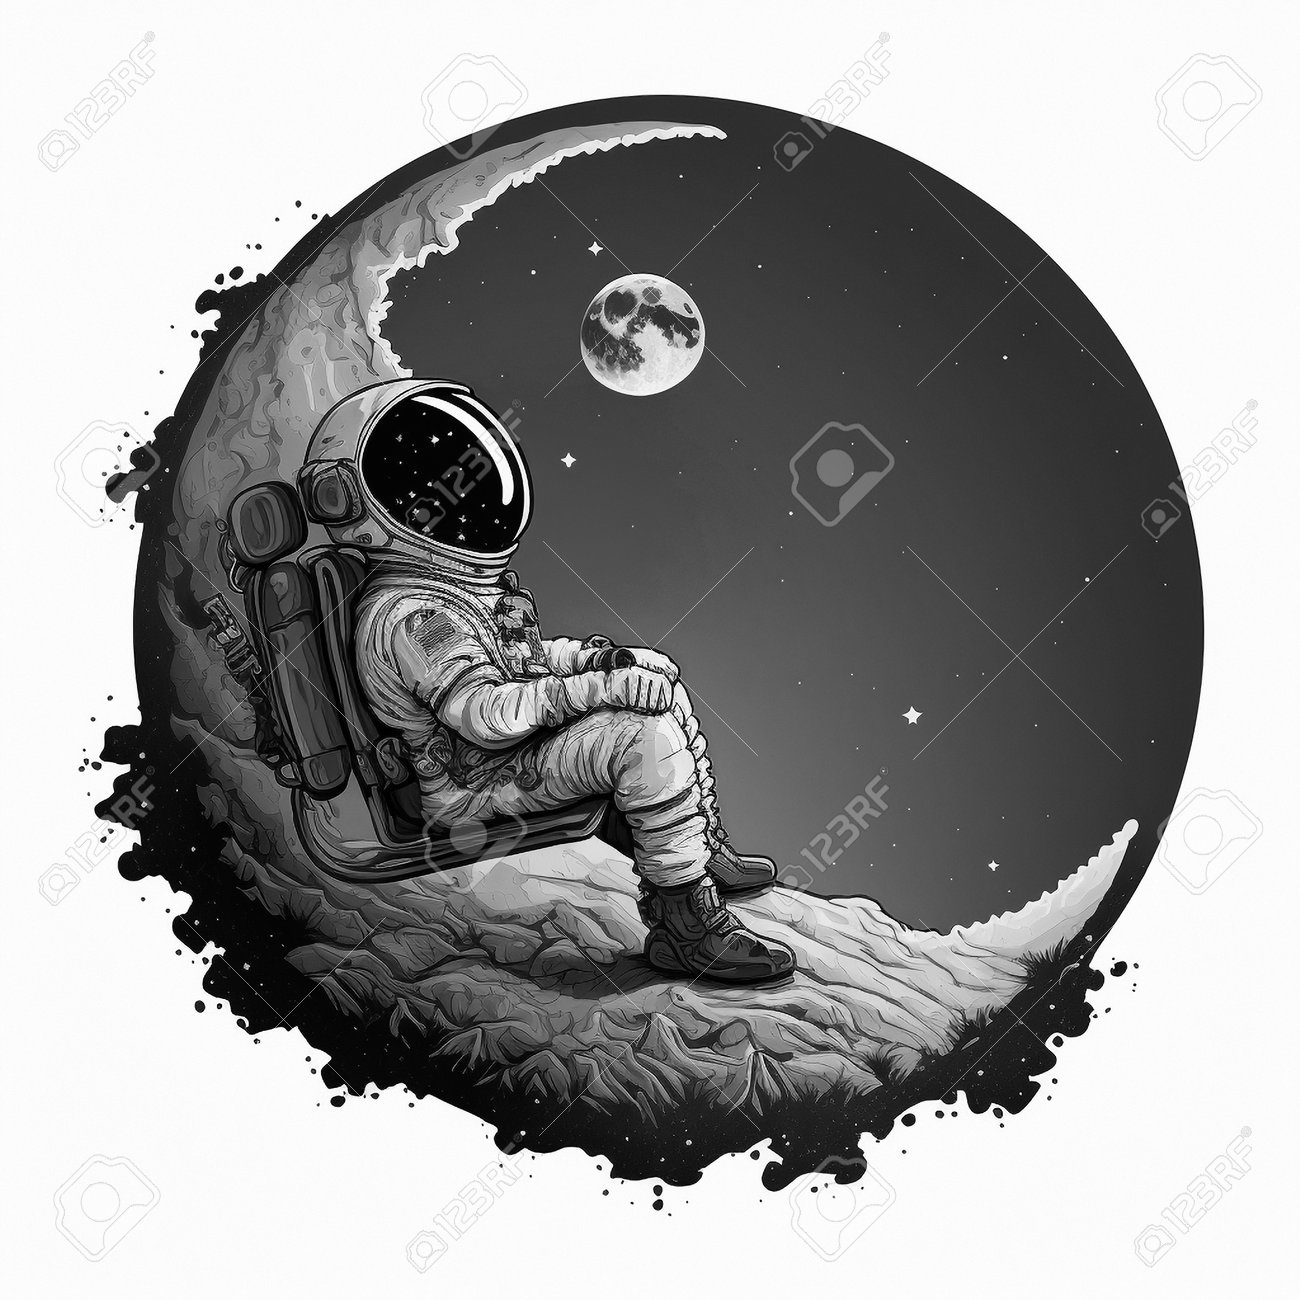

In [ ]:
path = "/content/imagen.jpg"
img = cargar_imagen(path)
img

## Veamos como se hace un filtro a pedal (sin estrategias paralelas)

Los **"kernels"**, también conocidos como matrices de convolución o filtros, son fundamentales en el procesamiento de imágenes y la visión por computadora. **Son matrices pequeñas** que se utilizan para aplicar efectos como desenfoque, nitidez, detección de bordes, entre otros, a una imagen.

#### **¿Qué es un Kernel?**


Un kernel es una matriz de $N×N$  


(donde N es usualmente un número impar como 3, 5, 7, etc.) que se aplica a cada píxel y sus vecinos en una imagen. Cada elemento de un kernel está asociado con un píxel vecino. Al multiplicar estos elementos con los píxeles vecinos y sumarlos, se obtiene un nuevo valor para el píxel original. Este proceso se repite para cada píxel de la imagen.

#### ¿Cómo Funcionan los Kernels en el Filtrado de Imágenes?

##### **Desplazamiento sobre la Imagen:**

El kernel se **"desliza"** sobre la imagen, posicionándose sucesivamente sobre cada píxel de la imagen.

En cada posición, los píxeles debajo del kernel se corresponden con los elementos de la matriz del kernel.

##### **Operación de Convolución:**

Para cada píxel bajo el kernel, se multiplica su valor por el valor correspondiente en el kernel.
Luego, se suman todos estos productos. Este total es el nuevo valor del píxel central en la imagen filtrada.

##### **Normalización (Opcional):**

En algunos casos, los valores del kernel se normalizan (por ejemplo, asegurándose de que sumen 1) para mantener el rango de intensidad de la imagen.

In [ ]:
def aplicar_filtro_bordes(imagen):
    # Convertir imagen a un array de numpy
    pixels = np.array(imagen)

    # Kernel de Sobel para bordes verticales
    kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Preparar el array de salida
    bordes = np.zeros_like(pixels)

    # Aplicar el filtro de Sobel solo en la dirección vertical
    for i in range(1, pixels.shape[0]-1):
        for j in range(1, pixels.shape[1]-1):
            gy = np.sum(np.multiply(pixels[i-1:i+2, j-1:j+2], kernel))
            bordes[i, j] = min(255, np.abs(gy))

    return Image.fromarray(bordes)

## Apliquemos el filtro a la imagen


Tiempo de ejecución: 16.858123302459717 segundos


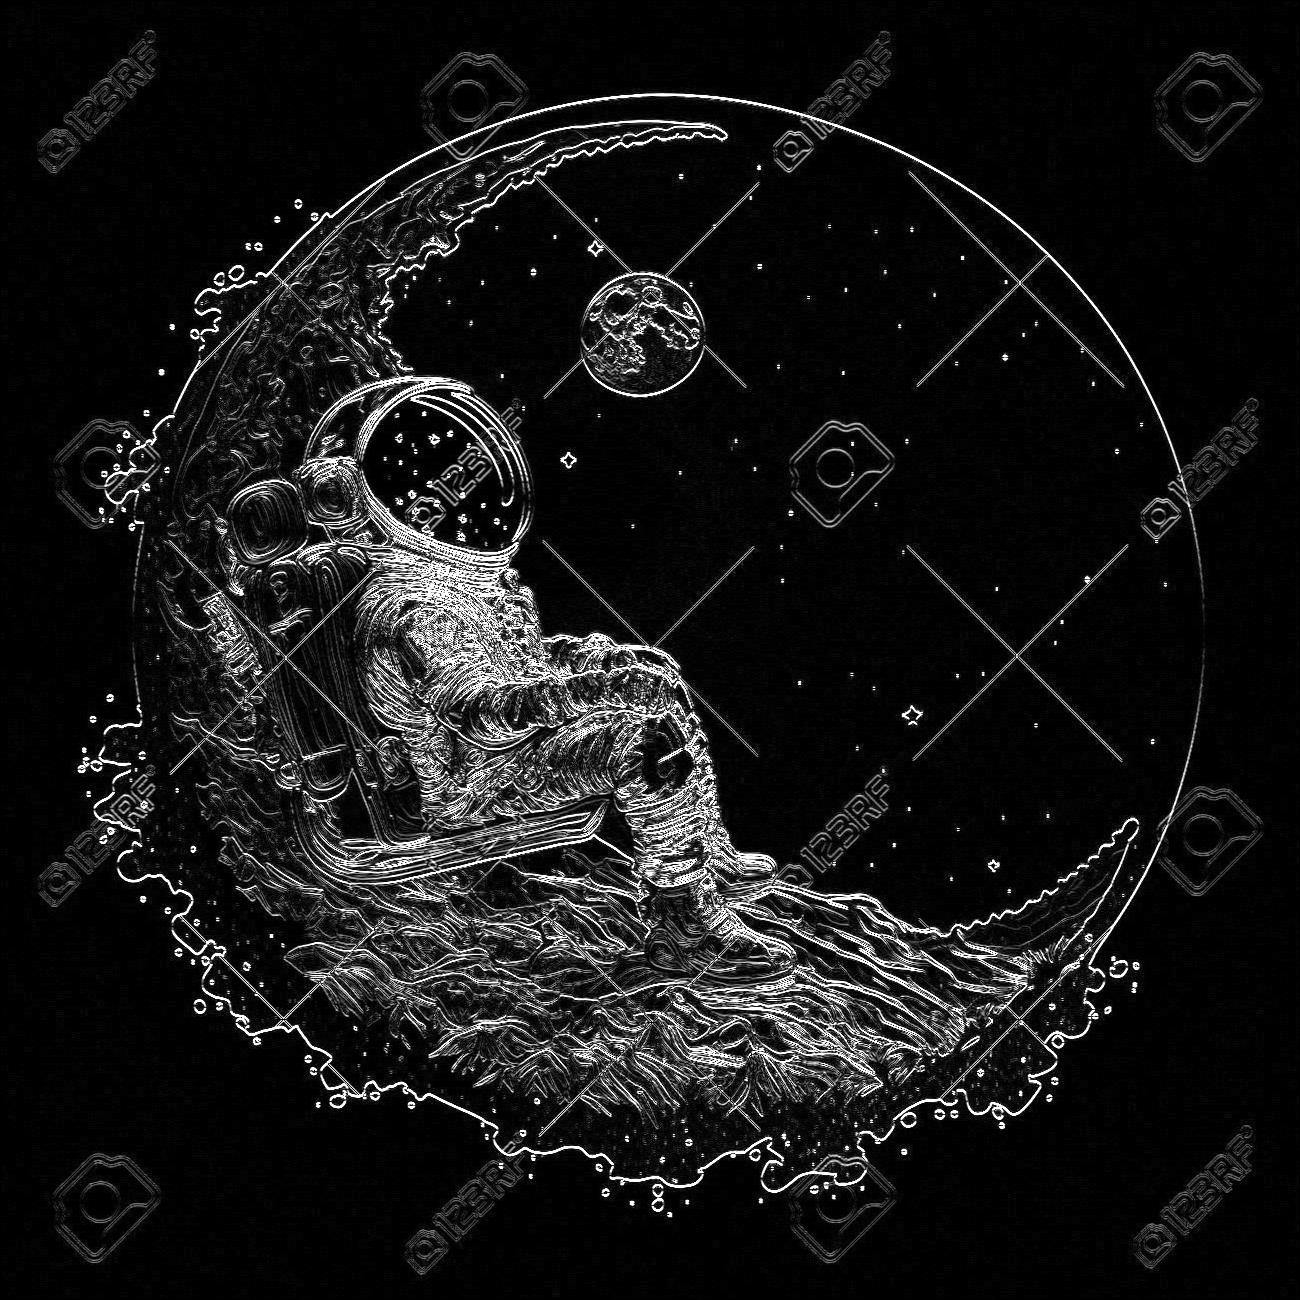

In [ ]:
imagen = cargar_imagen(path)

# Cargar y aplicar filtro
inicio = time.time()
imagen_bordes = aplicar_filtro_bordes(imagen)
fin = time.time()

# Imprimir tiempo de ejecución
print(f"Tiempo de ejecución: {fin - inicio} segundos")

# Visualizar la imagen
display(imagen_bordes)

In [ ]:
# Guardar imagen resultante
path_bordes = 'imagen_con_bordes.jpg'
guardar_imagen(imagen_bordes, path_bordes)

## Ahora revisemos una estrategia paralela. Multiprocessing

In [ ]:
import numpy as np
from PIL import Image
import time
from IPython.display import display
from multiprocessing import Pool, cpu_count

### Cambiemos un poco la lógica

In [ ]:
def aplicar_filtro_seccion(args):
    pixels, inicio, fin, ancho = args
    # Kernel de Sobel para bordes verticales
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    bordes_seccion = np.zeros_like(pixels[inicio:fin, :]) ## Ahora lo que va a hacer esto es a aplicar el filtro a un pedazo de la imagen.

    for i in range(1, fin - inicio - 1):
        for j in range(1, ancho - 1):
            gy = np.sum(np.multiply(pixels[i-1+inicio:i+2+inicio, j-1:j+2], kernel_y))
            bordes_seccion[i, j] = min(255, np.abs(gy))

    return bordes_seccion

In [ ]:
# Esta función se encarga de gestionar los procesos y los "pedazos" de imagen que le manda a cada proceso.

def aplicar_filtro_bordes_multiprocessing(imagen):
    pixels = np.array(imagen)
    alto, ancho = pixels.shape
    num_procesos = cpu_count()
    print("numero de procesos", num_procesos)

    # Dividir la imagen en secciones con superposición
    seccion_alto = alto // num_procesos
    secciones = []
    for i in range(num_procesos):
        inicio = i * seccion_alto
        fin = (i + 1) * seccion_alto if i != num_procesos - 1 else alto
        if i != 0:
            inicio -= 1  # Superposición para cubrir bordes
        secciones.append((pixels, inicio, fin, ancho))

    # Crear un pool de procesos y aplicar el filtro a cada sección
    with Pool() as pool:
        resultados = pool.map(aplicar_filtro_seccion, secciones)

    # Combinar los resultados
    bordes = np.vstack(resultados)

    return Image.fromarray(bordes)

numero de procesos 2
Tiempo de ejecución: 17.785150051116943 segundos


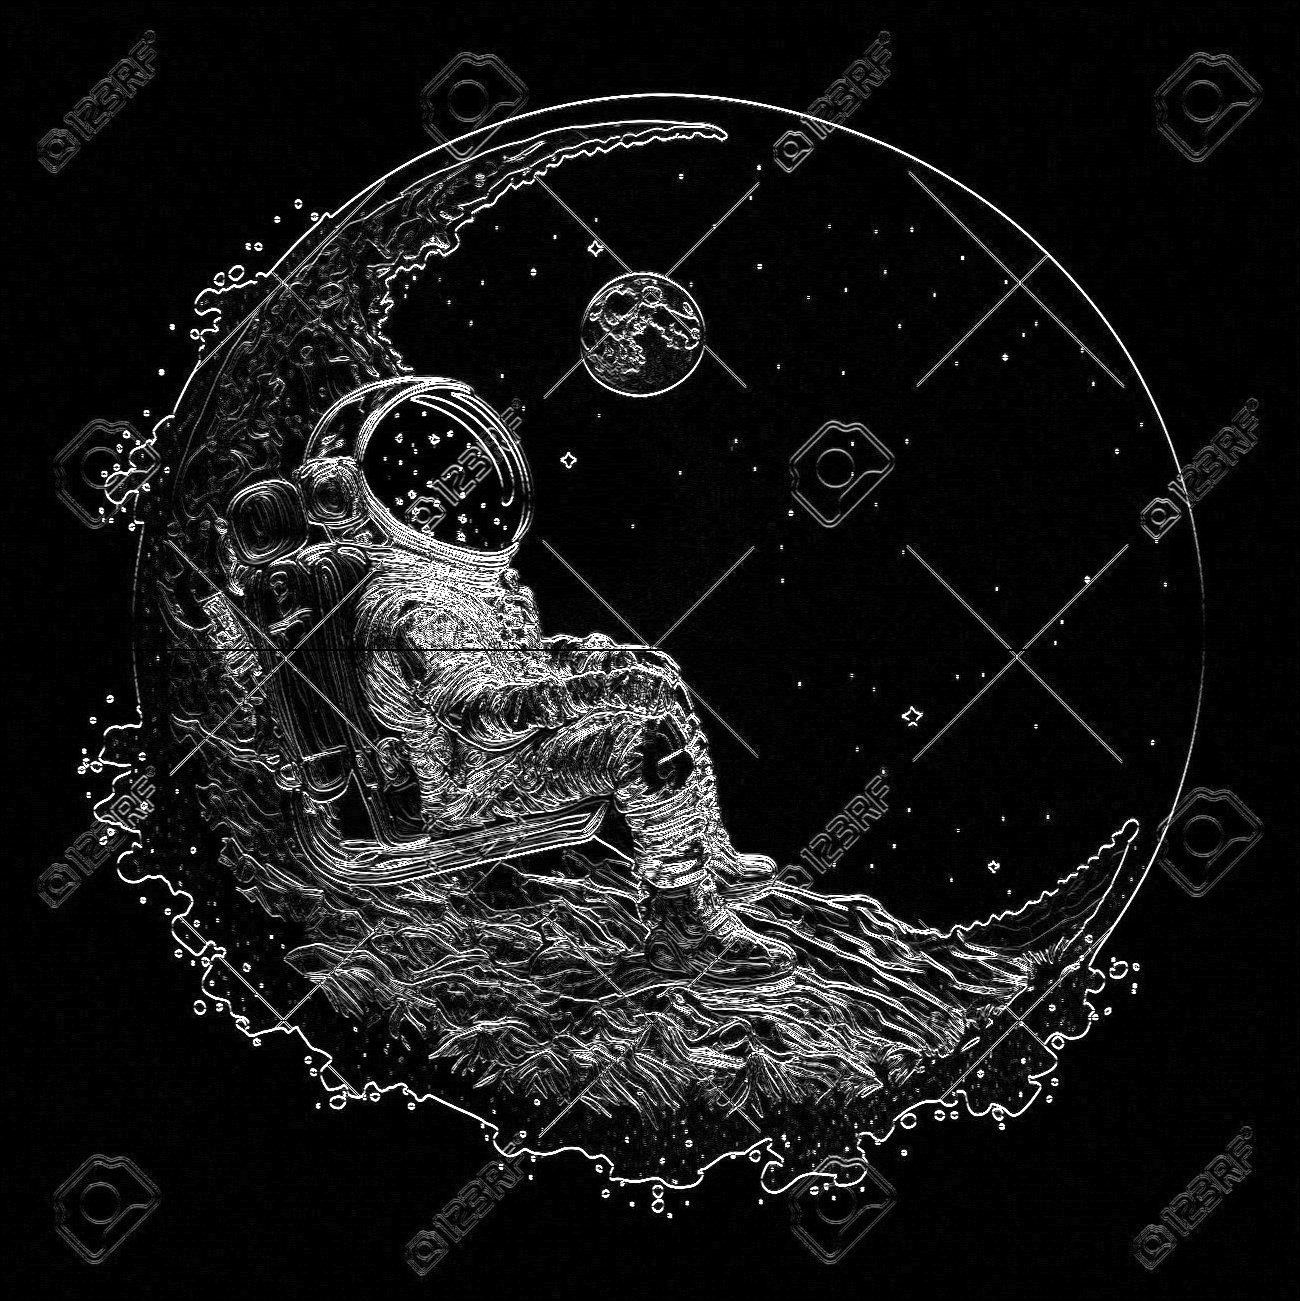

In [ ]:
# Cargar y aplicar filtro
imagen = Image.open(path).convert('L')


inicio = time.time()
imagen_bordes = aplicar_filtro_bordes_multiprocessing(imagen)
fin = time.time()

# Guardar imagen resultante
ruta_imagen_bordes = 'imagen_con_bordes.jpg'
imagen_bordes.save(ruta_imagen_bordes)

# Imprimir tiempo de ejecución
print(f"Tiempo de ejecución: {fin - inicio} segundos")

# Visualizar la imagen
display(imagen_bordes)